### This notebook is for research on the MIND paper from Tank lab-
- paper: https://www.biorxiv.org/content/10.1101/418939v2.full.pdf

### Goals 
1. Run some simulations from the MIND paper to replicate Figure 1
    - use the [RatInABox](https://github.com/TomGeorge1234/RatInABox) software to assist with simulations (at least for an agent trajectory, maybe more). Currently the RatInABox repository is located here: C:\Users\andrew\Documents\gitRepositories\RatInABox
2. Once I have a working model, try installing multiple environments in the same network of neurons, with the remapping performed in a few different ways. The different ways are listed below in the section "ideas to test". 

### Perspective
There is an open question in hippocampal neuroscience (I think...) about how spatial coding and recoding occurs. In particular, it is not known whether remapping is random and orthogonal, or constrained by intrinsic hippocampal architecture. I think it could be interesting and fruitful to combine a model of latent space (e.g., MIND) with simulated activity patterns based on experimentally-predicted assumptions about remapping and hippocampal architecture to learn how each assumptions affects the global manifold and each local manifold. 

### Ideas to Test
1. Losonczy lab - Geiller et al., 2021 - specific connection patterns between place cells and local inhibitory neurons
2. Spruston lab - The MEC/LEC anatomy - constrained inputs from MEC/LEC that are better than usual at driving plateau potentials


In [1]:
%load_ext autoreload
%autoreload 2

# Inclusions
import socket
import sys, os
if socket.gethostname()=='Andrews-MacBook-Pro.local':
    sys.path.append("/Users/landauland/Documents/GitHub/RatInABox")#os.path.join('C:/', 'Users','andrew','Documents','GitHub','RatInABox'))
    os.environ['NUMEXPR_NUM_THREADS'] = '8'
else:
    sys.path.append(os.path.join('C:/', 'Users','andrew','Documents','gitRepositories','RatInABox'))
    os.environ['NUMEXPR_MAX_THREADS'] = '16'

import time
import numpy as np
import numba as nb
import scipy
from scipy.spatial.distance import squareform, pdist, cdist
import matplotlib.pyplot as plt
import ratinabox
from ratinabox.Environment import Environment
from ratinabox.Agent import Agent
import mind_mindModel1 as mind
import mind_ppca1 as mppca
import mindAlgorithm1_Freeze as ogmind

from tqdm.notebook import tqdm, trange

In [2]:
# box coordinates
def getBoxCoord(boxLength,spacing=1):
    if not isinstance(spacing,int):
        raise ValueError("Spacing must be an integer")
    if not isinstance(boxLength,int):
        raise ValueError("Spacing must be an integer")
    xpos,ypos = np.meshgrid(np.arange(0,boxLength,spacing),np.arange(0,boxLength,spacing))
    return xpos,ypos

# random centroid selection (so can easily switch between random modes...)
def randCentroid(boxLength):
    xc = np.random.randint(0,boxLength) #np.random.random() * boxLength
    yc = np.random.randint(0,boxLength) #np.random.random() * boxLength
    return xc,yc

# return gaussian variance given a desired FWHM
def fwhmVar(x):
    return x**2 / (8*np.log(2))

# create place map given a centroid, place width, and room coordinates
def getPlaceMap(xcenter,ycenter,xpos,ypos,placeWidth):
    placeVar = fwhmVar(placeWidth)
    numerator = -(xpos - xcenter)**2 -(ypos-ycenter)**2
    denominator = 2*placeVar
    return np.exp(numerator / denominator)

# generate grid cell firing pattern (using Monaco & Abbott, 2011)
def getGridMap(xcenter,ycenter,xpos,ypos,gridSpacing,gridAngle):
    theta = np.array([-np.pi/3, 0, np.pi/3])
    u = lambda theta : np.array([np.cos(theta), np.sin(theta)])
    spOffsets = np.stack((xpos-xcenter, ypos-ycenter),axis=2)
    scaleFactor = (4*np.pi)/(np.sqrt(3)*gridSpacing)
    cosArgument = np.array([np.cos(scaleFactor*np.sum(spOffsets*u(theta[i]-gridAngle),axis=2)) for i in range(len(theta))])
    return np.sum(cosArgument,axis=0)

In [3]:
# Generate and plot some place cells and grid cells
NP = 50 # number of place cells
NG = 50 # number of grid cells
boxLength = 88 # 88cm box length (square arena)

gNoiseAmp = 1/5 # noise standard deviation relative to signal standard deviation

placeWidth = 41.6 # place field with in cm (full-width at half-maximum of an isotropic gaussian function)
numGridModules = 4 # number of grid modules (in increasing scale)
gridExpansion = 1.3 # relative scale increase of each consecutive grid module

baseGridSpacing = 39.8 # cm
baseGridWidth = 27.4 # cm (full-width at half-maximum of an isotropic gaussian function)
# they have something in the methods about lattice angle progressing by 15 degrees in each module, but I think I want to randomize it fully...

In [4]:
xpos,ypos = getBoxCoord(boxLength) 

# Create Library of Place Cells
xcPlace,ycPlace = zip(*[randCentroid(boxLength) for _ in range(NP)]) # centroid
placeLibrary = np.array([getPlaceMap(xcPlace[n],ycPlace[n],xpos,ypos,placeWidth) for n in range(NP)])

# Create Library of Grid Cells
xcGrid,ycGrid = zip(*[randCentroid(boxLength) for _ in range(NG)]) # centroid
spGrid = tuple(baseGridSpacing * (gridExpansion**np.random.randint(0,numGridModules)) for _ in range(NG)) # grid spacing
agGrid = tuple(np.pi/3*np.random.random() for _ in range(NG)) # angle of lattice
gridLibrary = np.array([getGridMap(xcGrid[n],ycGrid[n],xpos,ypos,spGrid[n],agGrid[n]) for n in range(NG)])

# Sanity Check!!
print(f'Shape of place library is {np.shape(placeLibrary)}')
print(f'Shape of grid library is {np.shape(gridLibrary)}')

Shape of place library is (50, 88, 88)
Shape of grid library is (50, 88, 88)


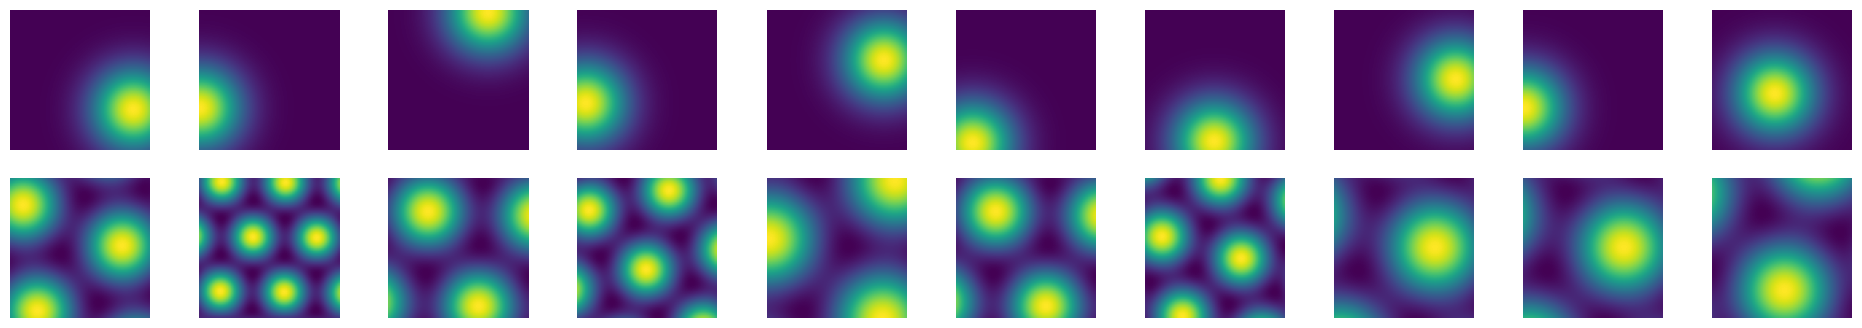

In [5]:
# Show Examples
numExamplesEach = 10
f, ax = plt.subplots(2,numExamplesEach,figsize=(24,4))
for n in range(numExamplesEach):
    ax[0,n].imshow(placeLibrary[np.random.randint(NP)])
    ax[1,n].imshow(gridLibrary[np.random.randint(NG)])
    ax[0,n].axis('off')
    ax[1,n].axis('off')

In [6]:
# Generate a trajectory in the environment
Env = Environment({"scale":boxLength/100}) # (RatInABox uses meters)
Ag = Agent(Env,{'dt':0.1})
for i in range(int(8000/Ag.dt)):
    Ag.update();

# Get trajectory variables
t, pos = np.array(Ag.history["t"]), np.array(Ag.history["pos"])
pos = pos * 100 # convert back to centimeters (to use as index)
posidx = np.floor(pos).astype('int8')

# Return place and grid cell activity along trajectory
placeActivity = placeLibrary[:,posidx[:,0],posidx[:,1]]
gridActivity = gridLibrary[:,posidx[:,0],posidx[:,1]]
hippoActivity = np.concatenate((placeActivity,gridActivity),axis=0)

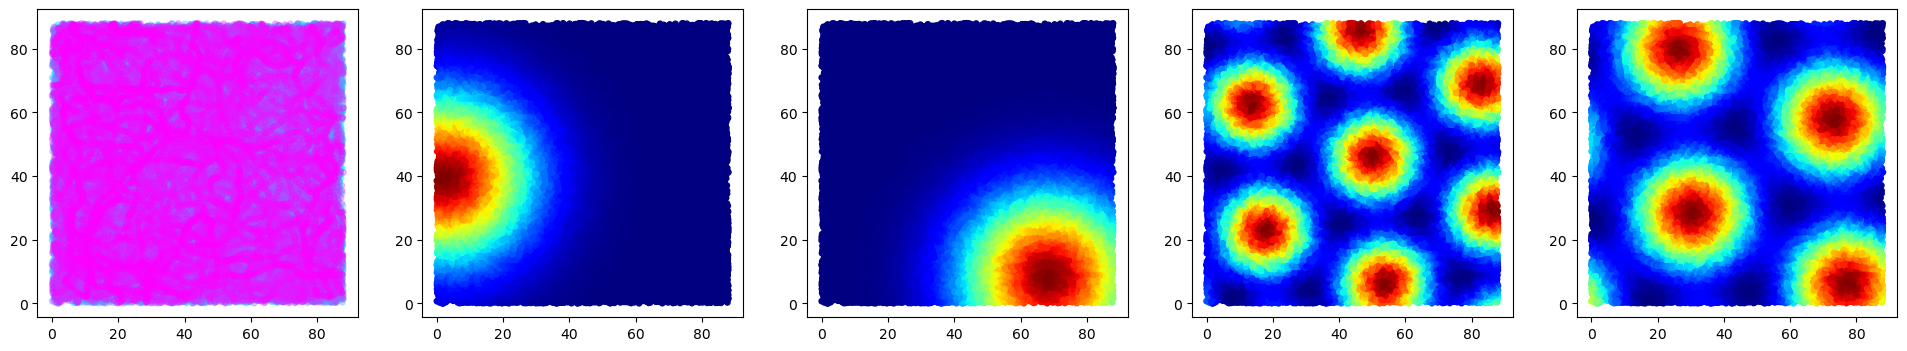

In [7]:
# Plot Trajectory and plot examples of place cell and grid cell activity overlaid on trajectory
numExamplesEach = 2
pexidx = np.random.randint(0,NP,numExamplesEach)
gexidx = np.random.randint(0,NG,numExamplesEach)
f, ax = plt.subplots(1,numExamplesEach*2+1,figsize=(24,4))
# Ag.plot_trajectory(ax=ax[0])
plt.set_cmap('cool')
ax[0].scatter(pos[:,0],pos[:,1],s=15,c=range(pos.shape[0]),alpha=0.3)
plt.set_cmap('jet')
for n in range(numExamplesEach):
    ax[n+1].scatter(pos[:,0],pos[:,1],s=15,c=placeActivity[pexidx[n],:])
    ax[n+1+numExamplesEach].scatter(pos[:,0],pos[:,1],s=15,c=gridActivity[gexidx[n],:])

In [9]:
opts = {'scaffoldPoints':800,'nLeaf':100}
numTrees = 50

placeMind = mind.mindModel(opts)
placeMind.addData(placeActivity.T)
placeMind.constructForest(numTrees)
placeMind.summarizeForest()
placeMind.constructScaffold()

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

In [10]:
opts = {'scaffoldPoints':800,'nLeaf':100}
numTrees = 50

hippoMind = mind.mindModel(opts)
hippoMind.addData(hippoActivity.T)
hippoMind.constructForest(numTrees)
hippoMind.summarizeForest()
hippoMind.constructScaffold()

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

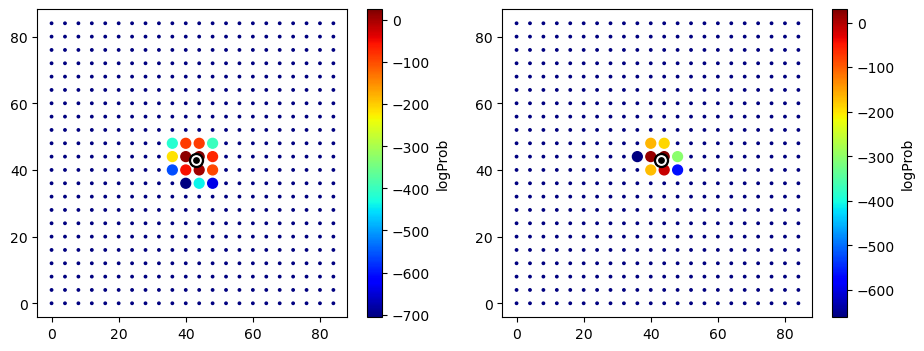

In [11]:
# Compute probability of transitions from one point to all other possible points
xp4,yp4 = getBoxCoord(boxLength,4)
xpv = xp4.reshape(-1)
ypv = yp4.reshape(-1)
placeMesh = (placeLibrary[:,xpv,ypv].T - placeMind.drPPCA.u) @ placeMind.drPPCA.v
hippoMesh = (np.concatenate((placeLibrary[:,xpv,ypv].T,gridLibrary[:,xpv,ypv].T),axis=1) - hippoMind.drPPCA.u) @ hippoMind.drPPCA.v

xC,yC = 43,43
placeCenter = (placeLibrary[:,xC,yC].T - placeMind.drPPCA.u) @ placeMind.drPPCA.v
hippoCenter = (np.concatenate((placeLibrary[:,xC,yC].reshape(1,-1),gridLibrary[:,xC,yC].reshape(1,-1)),axis=1) - hippoMind.drPPCA.u) @ hippoMind.drPPCA.v

placeMeshProb = placeMind.smartForestLikelihood(np.repeat(placeCenter.reshape(1,-1),placeMesh.shape[0],axis=0), placeMesh)
hippoMeshProb = hippoMind.smartForestLikelihood(np.repeat(hippoCenter.reshape(1,-1),hippoMesh.shape[0],axis=0), hippoMesh)

fig,ax = plt.subplots(1,2,figsize=(11,4))

placeNonzero = np.where(placeMeshProb != 0)[0]
placeZero = np.where(placeMeshProb == 0)[0]
cLimits = (np.min(np.log(placeMeshProb[placeNonzero])), np.max(np.log(placeMeshProb[placeNonzero])))
xx = ax[0].scatter(xpv[placeNonzero],ypv[placeNonzero],s=50,c=np.log(placeMeshProb[placeNonzero]),vmin=cLimits[0],vmax=cLimits[1])
ax[0].scatter(xpv[placeZero],ypv[placeZero],s=3,c=cLimits[0]*np.ones_like(xpv[placeZero]),vmin=cLimits[0],vmax=cLimits[1])
ax[0].scatter(xC,yC,s=100,c='k')
ax[0].scatter(xC,yC,s=45,c='w')
ax[0].scatter(xC,yC,s=15,c='k')
plt.colorbar(xx,ax=ax[0],label='logProb')

hippoNonzero = np.where(hippoMeshProb != 0)[0]
hippoZero = np.where(hippoMeshProb == 0)[0]
cLimits = (np.min(np.log(hippoMeshProb[hippoNonzero])), np.max(np.log(hippoMeshProb[hippoNonzero])))
xx = ax[1].scatter(xpv[hippoNonzero],ypv[hippoNonzero],s=50,c=np.log(hippoMeshProb[hippoNonzero]),vmin=cLimits[0],vmax=cLimits[1])
ax[1].scatter(xpv[hippoZero],ypv[hippoZero],s=3,c=cLimits[0]*np.ones_like(xpv[hippoZero]),vmin=cLimits[0],vmax=cLimits[1])
ax[1].scatter(xC,yC,s=100,c='k')
ax[1].scatter(xC,yC,s=45,c='w')
ax[1].scatter(xC,yC,s=15,c='k')
plt.colorbar(xx,ax=ax[1],label='logProb')

In [42]:
# Some print check statements 
# print(np.any(placeMind.scafDist==np.inf))
# print(np.all(placeMind.scafGridProb>=0) and np.all(placeMind.scafGridProb<=np.inf))
# print(np.all(placeMind.scafTrProb>=0) and np.all(placeMind.scafTrProb<=1))
# print(np.allclose(np.sum(placeMind.scafTrProb,axis=1),1))
# print(np.all(placeMind.scafLocalDist>=0))
# print(np.any(placeMind.scafLocalDist==np.inf))
# print(np.all(placeMind.scafGlobalDist>=0))
# print(np.any(placeMind.scafGlobalDist==np.inf))

In [75]:
# Implement MDS, optimize forward & reverse mappings
numDimsMDS = 4
placeMind.performMDS(numDimsMDS)
placeMind.optimizeForwardMapping()
placeMind.optimizeBackwardMapping()
hippoMind.performMDS(numDimsMDS)
hippoMind.optimizeForwardMapping()
hippoMind.optimizeBackwardMapping()

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

Alert: best lambda in optimizeForwardMapping was an edge case (the smallest option). Consider expanding search.


In [ ]:
# Now run data through mds and reconstructions with different dimensionalities
maxDims = 10
dimRec = np.arange(1,maxDims+1)
placeError = np.zeros(len(dimRec))
hippoError = np.zeros(len(dimRec))
for dri, drval in enumerate(dimRec):
    print(f"Working on reconstruction, D={drval}")
    # Produce a mapping of the landmark points
    placeMap.performMDS(drval, updateObject=True)
    hippoMap.performMDS(drval, updateObject=True)
    # Do forward and backward mapping of all the data
    cpForward = placeMap.forwardMapping(placeMap.drData)
    cpReconstruction = placeMap.backwardMapping(cpForward)
    chForward = hippoMap.forwardMapping(hippoMap.drData)
    chReconstruction = hippoMap.backwardMapping(chForward)
    # And Compute Error
    placeError[dri] = np.sqrt(np.sum((cpReconstruction - placeMap.drData)**2))
    hippoError[dri] = np.sqrt(np.sum((chReconstruction - hippoMap.drData)**2))

In [ ]:
fig, ax = plt.subplots(1,2,figsize=(8,4))
ax[0].plot(dimRec, placeError, c='k')
ax[0].set_xlabel('NumDims')
ax[0].set_ylabel('Error')
ax[0].set_title('Place Error')
ax[1].plot(dimRec, hippoError, c='k')
ax[1].set_xlabel('NumDims')
ax[1].set_ylabel('Error')
ax[1].set_title('Hippo Error')

## Some other code I've used for testing various things 

In [284]:
# Used for testing local functions and a mapping speed up
k = 50
lam = 1
numTest = 400
idxTest = np.random.choice(pfLandmark.shape[1],numTest,replace=False)
idxScaf = np.delete(np.arange(pfLandmark.shape[1]),idxTest)
testPoints = pfLandmark[:,idxTest].T
scafPoints = pfLandmark[:,idxScaf].T
scafTarget = pfSammon[idxScaf,:]
%time lmMapS = mind.mapping(pfLandmark[:,idxTest].T, pfLandmark[:,idxScaf].T, pfSammon[idxScaf,:], k, lam)

CPU times: total: 31.2 ms
Wall time: 18.9 ms


In [6]:
def checkOpts(userOpts={}):
    # Create default opts dictionary
    opts = {}
    opts['useScores'] = True # whether to use PPCA for dimreduction of data 
    # Opts for random forest
    opts['numTrees'] = 100 # how many trees to construct
    opts['nDir'] = 2 # how many directions to choose from at each split
    opts['nLeaf'] = 50 # minimum number of datapoints in each leaf 
    opts['nQuant'] = 8 # number of quantiles to choose threshold from

    # Update default opts with user requests
    assert userOpts.keys() <= opts.keys(), "userOpts contains invalid keys"
    opts.update(userOpts)
    
    return opts

userOpts = {'useScores':False}
newOpts = checkOpts(userOpts)
print(newOpts)

{'useScores': False, 'numTrees': 100, 'nDir': 2, 'nLeaf': 50, 'nQuant': 8}


In [9]:
import mindAlgorithm1_Freeze as mind

(49, 8000)
[9.36612407e-01 8.97999966e-01 4.48880381e-01 3.21449043e-01
 2.60433555e-01 1.35028746e-01 8.56231067e-02 5.46089194e-02
 3.28660520e-02 3.04885092e-02 2.24750336e-02 1.69481591e-02
 1.11181314e-02 6.89986267e-03 5.09351221e-03 2.59318456e-03
 1.78861701e-03 1.35517852e-03 9.68724445e-04 4.64705386e-04
 3.65232561e-04 2.54873664e-04 1.85221751e-04 8.06657521e-05
 6.99370864e-05 6.35733571e-05 5.20374101e-05 2.79492653e-05
 1.33687676e-05 1.02348912e-05 5.01638606e-06 3.21868574e-06
 2.63279797e-06 2.13811513e-06 1.28057122e-06 6.54766930e-07
 3.68877538e-07 3.16695255e-07 2.68302047e-07 1.64590052e-07
 1.07014832e-07 5.35684739e-08 4.18583118e-08 2.96642812e-08
 2.10655474e-08 6.72382384e-09 2.30196083e-09 1.52129018e-09
 2.51723768e-10]
False
True


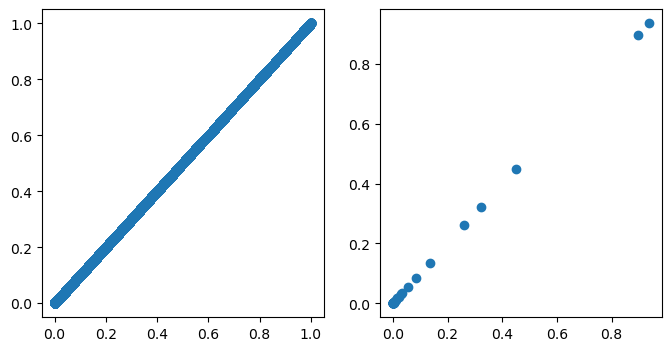

In [37]:
lPlace,uPlace,covPlace,nvPlace,wPlace,vPlace = mind.ppca(placeActivity.T,minVariance=0.999999999999999)
pfScores = vPlace.T @ (placeActivity - uPlace.reshape(-1,1))
pfReconstruction = vPlace @ pfScores + uPlace.reshape(-1,1)

print(pfScores.shape)
pfScrVar = np.var(pfScores,axis=1)
print(pfScrVar)
print(np.allclose(pfReconstruction, placeActivity))
print(np.allclose(pfScrVar, wPlace))
fig,ax = plt.subplots(1,2,figsize=(8,4))
ax[0].scatter(placeActivity, pfReconstruction)
ax[1].scatter(wPlace, pfScrVar)

In [162]:
from sklearn.datasets import make_spd_matrix as spd
xx = spd(500)
G = np.linalg.cholesky(xx)
print(f"Determinant: {np.linalg.det(xx)}")
print(f"SmartDet:    {(np.prod(np.diag(G)))**2}")
print(f"WeirdDet:    {np.exp(2*np.sum(np.log(np.diag(G))))}")
print(f"Log Determinant:   {np.log(np.linalg.det(xx))}")
print(f"Log Det Cholesky:  {2*np.log(np.linalg.det(G))}")
print(f"Log Smart Chol:    {2*np.log(np.prod(np.diag(G)))}")
print(f"Log Smarter Chol:  {2*np.sum(np.log(np.diag(G)))}")

Determinant: 2.1204785052493824e-215
SmartDet:    2.1204785150201225e-215
WeirdDet:    2.12047851502009e-215
Log Determinant:   -494.3041532204813
Log Det Cholesky:  -494.3041532158734
Log Smart Chol:    -494.3041532158735
Log Smarter Chol:  -494.3041532158735


In [ ]:
prob = np.random.randint(5, size=4) /4
print(prob)

result = np.where(prob > 0, prob, np.inf)
print(result)
np.log10(result, out=result, where=result > 0)
# -np.log(0)

[0. 1. 1. 1.]
[inf  1.  1.  1.]


array([inf,  0.,  0.,  0.])

In [193]:
def sizeof_fmt(num, suffix='B'):
    ''' by Fred Cirera,  https://stackoverflow.com/a/1094933/1870254, modified'''
    for unit in ['','Ki','Mi','Gi','Ti','Pi','Ei','Zi']:
        if abs(num) < 1024.0:
            return "%3.1f %s%s" % (num, unit, suffix)
        num /= 1024.0
    return "%.1f %s%s" % (num, 'Yi', suffix)

for name, size in sorted(((name, sys.getsizeof(value)) for name, value in locals().items()),
                         key= lambda x: -x[1])[:10]:
    print("{:>30}: {:>8}".format(name, sizeof_fmt(size)))

                   hpcActivity: 61.0 MiB
                     hpcScores: 11.6 MiB
                      pfLmProb:  4.9 MiB
                     hpcLmProb:  4.9 MiB
                 pfLmLocalDist:  4.9 MiB
                hpcLmLocalDist:  4.9 MiB
                      pfLmDist:  4.9 MiB
                     hpcLmDist:  4.9 MiB
                    pfDistCMDS:  4.9 MiB
                   hpcDistCMDS:  4.9 MiB


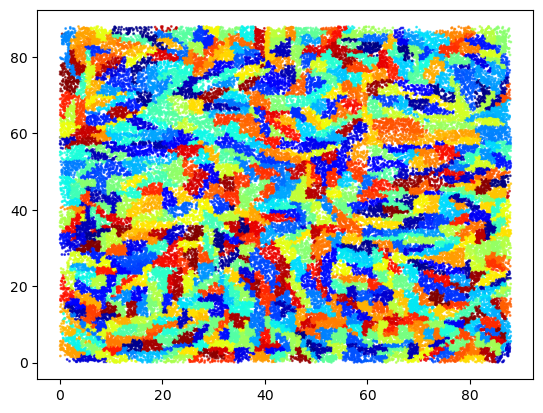

In [196]:
useTreeIdx = 0
pathIndices = mind.returnPathIndexLoop(pfScores,placeForest['tree'][useTreeIdx])
numPaths = len(placeForest['treeSummary'][useTreeIdx])
randIndexDict = dict(zip(np.arange(numPaths),np.random.permutation(numPaths)))
plt.scatter(pos[:,0],pos[:,1],s=1,c=[randIndexDict[pi] for pi in pathIndices],alpha=0.7)

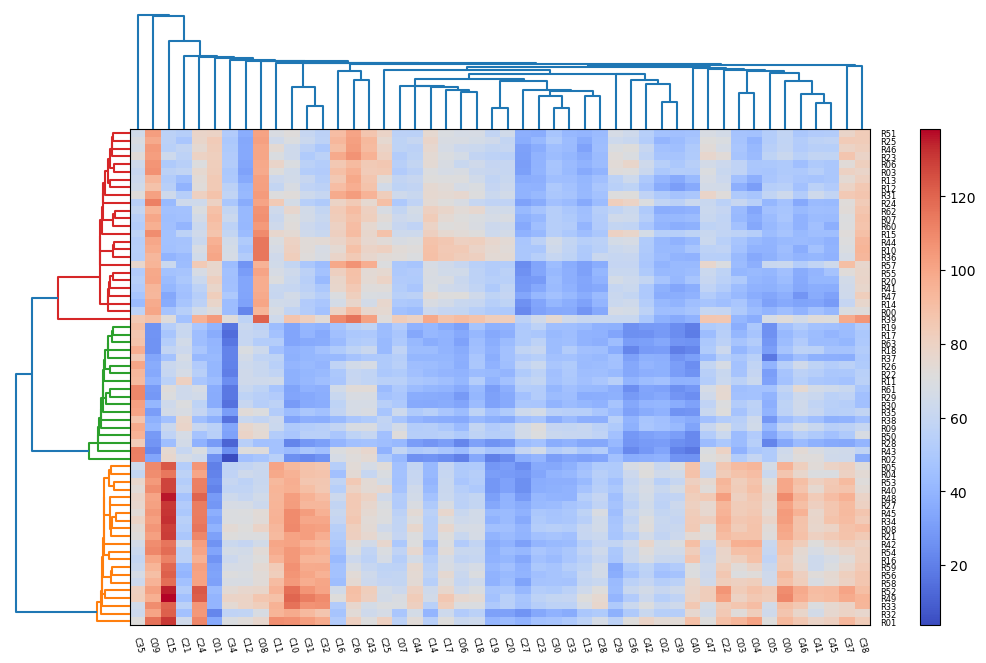

In [53]:
import numpy as np
import matplotlib.pyplot as plt
from heatMapCluster import heatmapcluster


def make_data(size, seed=None):
    if seed is not None:
        np.random.seed(seed)

    s = np.random.gamma([7, 6, 5], [6, 8, 6], size=(size[1], 3)).T
    i = np.random.choice(range(len(s)), size=size[0])
    x = s[i]

    t = np.random.gamma([8, 5, 6], [3, 3, 2.1], size=(size[0], 3)).T
    j = np.random.choice(range(len(t)), size=size[1])

    x += 1.1*t[j].T

    x += 2*np.random.randn(*size)

    row_labels = [('R%02d' % k) for k in range(x.shape[0])]
    col_labels = [('C%02d' % k) for k in range(x.shape[1])]

    return x, row_labels, col_labels


x, row_labels, col_labels = make_data(size=(64, 48), seed=123)

h = heatmapcluster(x, row_labels, col_labels,
                   num_row_clusters=3, num_col_clusters=0,
                   label_fontsize=6,
                   xlabel_rotation=-75,
                   cmap=plt.cm.coolwarm,
                   show_colorbar=True,
                   top_dendrogram=True)
plt.show()

In [115]:
import torch
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [191]:
data = pfScores[:,:10].T
weights = np.ones(data.shape[0])
udata = np.average(data, axis=0, weights=weights)
cdata = data - udata



In [192]:
data = pfScores[:,:10].T
weights = np.maximum(np.random.normal(0,0.2,(data.shape[0]))+1,0.1) #np.ones(data.shape[0])
udata = np.average(data, axis=0, weights=weights)
cdata = data - udata

torchData = torch.tensor(cdata, device=device).float().T; 
torchWeights = torch.tensor(weights, device=device).float();

%time wcovData = (1/np.sum(weights)) * (cdata.T @ np.diag(weights) @ cdata)
%time rcovData = np.cov(cdata.T, bias=True, aweights=weights)
%time tcovData = torch.cov(torchData,correction=0,aweights=torchWeights)

CPU times: total: 0 ns
Wall time: 0 ns
CPU times: total: 0 ns
Wall time: 0 ns
CPU times: total: 15.6 ms
Wall time: 997 µs


In [190]:
torch.allclose(torch.tensor(wcovData,device=device).float(),tcovData)

True

In [207]:
xxx = np.arange(5).reshape(-1,1) + np.arange(5).reshape(1,-1)
xxx = xxx - np.diag(np.diag(xxx))
print(xxx)
print(squareform(xxx))

[[0 1 2 3 4]
 [1 0 3 4 5]
 [2 3 0 5 6]
 [3 4 5 0 7]
 [4 5 6 7 0]]
[1 2 3 4 3 4 5 5 6 7]


In [134]:
nb.__version__

'0.55.1'

In [135]:
np.__version__

'1.21.5'

In [98]:
u.T.shape

(6, 800)

In [107]:
import numba as nb
import numpy as np

def fastGrid(data, u, iS, logDet, D): 
    N = data.shape[1] 
    probability = np.zeros((N,N))
    for n in range(N):
        udata = data - u[:,n].reshape(-1,1)
        cexparg = np.sum((iS[:,:,n] @ udata) * udata,axis=0)
        cloglikelihood = -D/2*np.log(2*np.pi) - 1/2*logDet[n] - cexparg/2
        probability[n,:] = np.exp(cloglikelihood)
    return probability

def mindGrid(data,u,iS,logDet,D):
    N = data.shape[1]
    probability = np.zeros((N,N))
    for n in range(N):
        cudata = data - u[:,n].reshape(D,1)
        cexparg = (-1/2) * np.sum((iS[:,:,n] @ cudata) * cudata, axis=0)
        cloglik = -D/2*np.log(2*np.pi) - 1/2*logDet[n] + cexparg
        probability[n,:] = np.exp(cloglik)
    return probability

@nb.njit(nb.float64[:,::1](nb.float64[:,::1],nb.float64[:,::1],nb.float64[:,:,::1],nb.float64[::1],nb.float64), nogil=True, parallel=True)
def fastGridNC(data, u, iS, logDet, D): 
    N = data.shape[0] 
    probability = np.zeros((N,N))
    for n in nb.prange(N):
        udata = np.zeros_like(data)
        # subtract mean
        for n1 in range(N):
            udata[n1,:] = data[n1,:] - u[n,:]
        cexpargmat = (udata @ iS[n]) * udata
        cexparg = np.zeros_like(logDet)
        for n1 in range(N):
            cexparg[n1] = np.sum(cexpargmat[n1,:])
        cloglikelihood = -D/2*np.log(2*np.pi) - 1/2*logDet[n] - cexparg/2
        probability[n,:] = np.exp(cloglikelihood)
    return probability

@nb.njit(nb.float64[:,::1](nb.float64[:,::1],nb.float64[:,::1],nb.float64[:,:,::1],nb.float64[::1],nb.float64), nogil=True, parallel=True)
def difGridNC(data, u, iS, logDet, D): 
    N = data.shape[0] 
    probability = np.zeros((N,N))
    for n in nb.prange(N):
        udata = np.zeros_like(data)
        # subtract mean
        for n1 in range(N):
            udata[n1] = data[n1] - u[n]
        cexpargmat = (udata @ iS[n]) * udata
        cexparg = np.zeros_like(logDet)
        for n1 in range(N):
            cexparg[n1] = np.sum(cexpargmat[n1])
        cloglikelihood = -D/2*np.log(2*np.pi) - 1/2*logDet[n] - cexparg/2
        probability[n] = np.exp(cloglikelihood)
    return probability

tt = 0
T = 5
data = pfLandmark
D,N = data.shape
v0 = np.zeros((N,N,T))
v1 = np.zeros((N,N,T))
v2 = np.zeros((N,N,T))
# for tt in range(T):
tt=0
tPathIdx = mind.returnPathIndexLoop(data, placeForest['tree'][tt])
u = placeForest['ppcaMeans'][tt][tPathIdx,:]
iS = placeForest['ppcaInvCovs'][tt][tPathIdx,:,:]
logDet = placeForest['ppcaLogDets'][tt][tPathIdx]

tdata = np.ascontiguousarray(data.T)
tu = u
tiS = iS
tLogDet = logDet

# v0[:,:,tt] = fastGrid(data,u.T,iS.transpose(1,2,0),logDet,D)
# v1[:,:,tt] = mindGrid(data,u.T,iS.transpose(1,2,0),logDet,D)
# v2[:,:,tt] = fastGridNC(tdata,tu,tiS,tlogDet,D)

# xxx = mind.smartGridProbability(pfLandmark, placeForest)
# yyy = mind.numbaGridProbability(pfLandmark, placeForest)
# %timeit v0 = fastGrid(data,u,iS,logDet,D)
%timeit v1 = difGridNC(tdata,tu,tiS,tLogDet,D)
%timeit v2 = fastGridNC(tdata,tu,tiS,tLogDet,D)

print(np.allclose(v0,v1))
print(np.allclose(v0,v2))
print(np.allclose(v1,v2))
print(np.allclose(xxx,yyy))

59.7 ms ± 155 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
3.48 ms ± 63.7 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
True
True
True
True


In [42]:
len(placeForest['tree'])

5

In [23]:
import numpy as np 
N,D = 100,7
data = np.random.normal(0,1,(D,N))
u = np.random.normal(0,1,(D,N))
iS = np.random.normal(0,1,(D,D,N))
logDet = np.random.normal(10,1,N)

udata = np.random.normal(0,1,(D,N,N))
mexp = np.zeros((N,N))
for n1 in range(N):
    for n2 in range(N):
        mexp[n1,n2] = udata[:,n1,n2] @ iS[:,:,n2] @ udata[:,n1,n2]
einexp = np.einsum('dnm,ddm,dnm -> nm',udata, iS, udata) 

ein1 = np.einsum('ddm,dnm -> dnm', iS, udata)
ein2 = np.einsum('dnm,dnm -> nm', udata, ein1)
print(mexp.shape)
print(einexp.shape)
print(np.allclose(mexp,einexp.T))
print(np.allclose(mexp,ein2))

(100, 100)
(100, 100)
False
False
